# Developing `make_ww3_current_file` Worker

Code experiments and verification for the `make_ww3_current_file` worker.

wwatch3 requires the ocean current forcing file that is input to `ww3_prnc`
to have a structure similar this file:

```
netcdf GSL5km_2009_CUR {
dimensions:
    longitude = 150 ;
    latitude = 236 ;
    time = UNLIMITED ; // (8760 currently)
variables:
    double time(time) ;
        time:long_name = "Time" ;
        time:time_origin = "2009-01-01 01:00:00" ;
        time:delta_t = "0000-00-00 01:00:00" ;
        time:units = "days since 2009-01-01T01:00:00Z" ;
    double latitude(latitude, longitude) ;
        latitude:long_name = "Latitude" ;
        latitude:units = "degrees_north" ;
    double longitude(latitude, longitude) ;
        longitude:long_name = "Longitude" ;
        longitude:units = "degrees_east" ;
    double uas(time, latitude, longitude) ;
        uas:standard_name = "uas" ;
        uas:long_name = "East component of current" ;
        uas:units = "m s-1" ;
    double vas(time, latitude, longitude) ;
        vas:standard_name = "vas" ;
        vas:long_name = "North component of current" ;
        vas:units = "m s-1" ;

```
(Example courtesy of Caroline Sevigny at Université du Québec à Rimouski)

The worker needs to:

* use `time_counter` from `grid_U.nc` or `grid_V.nc` file,
and rename it to `time`

* use `nav_lon` and the `mesh_mask` file,
and rename them to `longitude` and `latitude`

* unstagger the top grid cell
(nominally 0.5 m depth)
values of the `vozocrtx` and `vomecrty` variables from `grid_U.nc` and `grid_V.nc` files
on to the `nav_lon` and `nav_lat` of the `mesh_mask` file

* rotate the unstaggered velocity component arrays from NEMO grid orientation to NS map orientation

* rename the unstaggered and rotated velocity component arrays to `u_current` and `v_current`

to produce an netCDF4 file with a structure similar to above that `ww3_prnc` will accept.

In [65]:
import arrow
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

from salishsea_tools import viz_tools

In [2]:
%matplotlib inline

In [3]:
mesh_mask = xr.open_dataset('/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_downbyone2.nc')
mesh_mask

<xarray.Dataset>
Dimensions:       (t: 1, x: 398, y: 898, z: 40)
Dimensions without coordinates: t, x, y, z
Data variables:
    e1f           (t, y, x) float64 413.6 424.0 431.4 437.0 441.4 445.0 ...
    e1t           (t, y, x) float64 397.1 415.8 426.5 433.6 438.9 443.0 ...
    e1u           (t, y, x) float64 406.5 421.1 430.0 436.2 440.9 444.7 ...
    e1v           (t, y, x) float64 407.5 419.7 428.3 434.5 439.4 443.4 ...
    e2f           (t, y, x) float64 455.0 455.0 455.0 455.0 455.0 455.0 ...
    e2t           (t, y, x) float64 455.2 455.1 455.1 455.1 455.1 455.1 ...
    e2u           (t, y, x) float64 455.2 455.1 455.1 455.1 455.1 455.1 ...
    e2v           (t, y, x) float64 455.0 455.0 455.0 455.0 455.0 455.0 ...
    e3t_0         (t, z, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    e3t_1d        (t, z) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.001 1.002 ...
    e3u_0         (t, z, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    e3v_0         (t, z, y, x

In [4]:
u_nemo = xr.open_dataset('/results/SalishSea/nowcast-blue/11apr17/SalishSea_1h_20170411_20170411_grid_U.nc')
u_nemo

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthu: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
  * depthu                (depthu) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    nav_lat               (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    nav_lon               (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_centered         (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
  * time_counter          (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    area                  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bounds_lat            (y, x, nvertex) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bounds_lon            (y, x, nvertex) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    depthu_bounds         (depthu, axis_nbounds) float32 0.0 1.0 1.0 2.00001 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 3.701e+09 

In [5]:
u_nemo.vozocrtx[:, 0, ...]

<xarray.DataArray 'vozocrtx' (time_counter: 24, y: 898, x: 398)>
[8577696 values with dtype=float64]
Coordinates:
    depthu         float32 0.5
    nav_lat        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    nav_lon        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_centered  (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
  * time_counter   (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name: sea_water_x_velocity
    long_name: ocean current along i-axis
    units: m/s
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 h
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area

In [6]:
v_nemo = xr.open_dataset('/results/SalishSea/nowcast-blue/11apr17/SalishSea_1h_20170411_20170411_grid_V.nc')
v_nemo

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthv: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
  * depthv                (depthv) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    nav_lat               (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    nav_lon               (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_centered         (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
  * time_counter          (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    area                  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bounds_lat            (y, x, nvertex) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bounds_lon            (y, x, nvertex) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    depthv_bounds         (depthv, axis_nbounds) float32 0.0 1.0 1.0 2.00001 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 3.701e+09 

In [7]:
v_nemo.vomecrty[:, 0, ...]

<xarray.DataArray 'vomecrty' (time_counter: 24, y: 898, x: 398)>
[8577696 values with dtype=float64]
Coordinates:
    depthv         float32 0.5
    nav_lat        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    nav_lon        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_centered  (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
  * time_counter   (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name: sea_water_y_velocity
    long_name: ocean current along j-axis
    units: m/s
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 h
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area

In [8]:
u_unstaggered, v_unstaggered = viz_tools.unstagger(u_nemo.vozocrtx[:, 0, ...], v_nemo.vomecrty[:, 0, ...])
for coord in ('nav_lat', 'nav_lon', 'time_centered'):
    del u_unstaggered.coords[coord]
    del v_unstaggered.coords[coord]
del u_unstaggered.coords['depthu']
del v_unstaggered.coords['depthv']
u_unstaggered, v_unstaggered

(<xarray.DataArray 'vozocrtx' (time_counter: 24, y: 897, x: 397)>
 array([[[ nan,  nan, ...,  nan,  nan],
         [ nan,  nan, ...,  nan,  nan],
         ..., 
         [  0.,   0., ...,  nan,  nan],
         [  0.,   0., ...,  nan,  nan]],
 
        [[ nan,  nan, ...,  nan,  nan],
         [ nan,  nan, ...,  nan,  nan],
         ..., 
         [  0.,   0., ...,  nan,  nan],
         [  0.,   0., ...,  nan,  nan]],
 
        ..., 
        [[ nan,  nan, ...,  nan,  nan],
         [ nan,  nan, ...,  nan,  nan],
         ..., 
         [  0.,   0., ...,  nan,  nan],
         [  0.,   0., ...,  nan,  nan]],
 
        [[ nan,  nan, ...,  nan,  nan],
         [ nan,  nan, ...,  nan,  nan],
         ..., 
         [  0.,   0., ...,  nan,  nan],
         [  0.,   0., ...,  nan,  nan]]])
 Coordinates:
   * time_counter  (time_counter) datetime64[ns] 2017-04-11T00:30:00 ...
 Dimensions without coordinates: y, x,
 <xarray.DataArray 'vomecrty' (time_counter: 24, y: 897, x: 397)>
 array([[[ nan,  

In [9]:
u_current, v_current = viz_tools.rotate_vel(u_unstaggered, v_unstaggered)

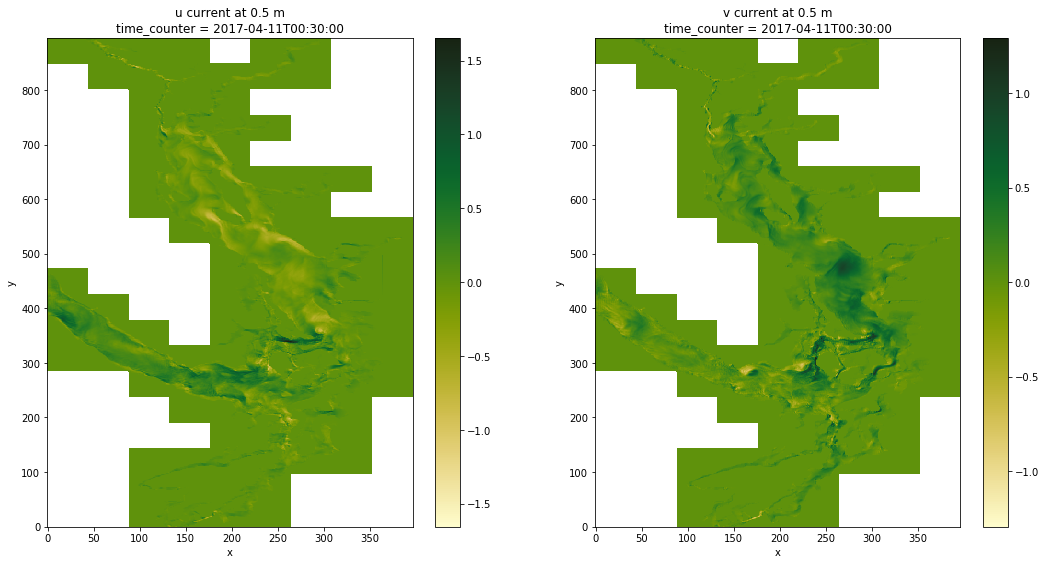

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 9))
u_current[0].plot(ax=ax0, cmap=cmocean.cm.speed)
ax0.set_title('u current at 0.5 m\n' + ax0.get_title())
v_current[0].plot(ax=ax1, cmap=cmocean.cm.speed)
ax1.set_title('v current at 0.5 m\n' + ax1.get_title())

We need to create a new dataset with:

* the `time_counter` coordinate renamed to `time` because that is the coordinate/dimension name that `ww3_prnc` expects
* a `latitude` coordinate derived from the `nav_lat` variable because that is one of the variable names that `ww3_prnc` expects
* a `longitude` coordinate derived from the `nav_lon` variable because that is one of the variable names that `ww3_prnc` expects
* a `u_wind` variable with its `time_counter` coordinate renamed to `time`
* a `v_wind` variable with its `time_counter` coordinate renamed to `time`

In [11]:
ds = xr.Dataset(
    data_vars={
        'u_current': u_current.rename({'time_counter': 'time'}),
        'v_current': v_current.rename({'time_counter': 'time'}),
    },
    coords={
        'time': u_nemo.time_counter.rename('time').rename({'time_counter': 'time'}),
        'latitude': mesh_mask.nav_lat[1:, 1:],
        'longitude': mesh_mask.nav_lon[1:, 1:],
    }
)
del ds.coords['time_centered']
ds

<xarray.Dataset>
Dimensions:    (time: 24, x: 397, y: 897)
Coordinates:
  * time       (time) datetime64[ns] 2017-04-11T00:30:00 2017-04-11T01:30:00 ...
    latitude   (y, x) float32 46.8648 46.8668 46.8687 46.8706 46.8725 ...
    longitude  (y, x) float32 -123.427 -123.422 -123.416 -123.411 -123.406 ...
Dimensions without coordinates: x, y
Data variables:
    u_current  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    v_current  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...

The `time_centered` coordinate is deleted because it is an artifact from NEMO
that has no relevance for wwatch3.

In [12]:
ds.to_netcdf('SoG_current_20170411.nc')

In [13]:
!/usr/bin/ncdump -cst SoG_current_20170411.nc

netcdf SoG_current_20170411 {
dimensions:
	time = 24 ;
	y = 897 ;
	x = 397 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ; // NaN
		time:axis = "T" ;
		time:standard_name = "time" ;
		time:long_name = "Time axis" ;
		time:time_origin = "1900-01-01 00:00:00" ;
		time:bounds = "time_counter_bounds" ;
		time:units = "seconds since 1900-01-01" ;
		time:calendar = "gregorian" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_DeflateLevel = 4 ;
		time:_Shuffle = "true" ;
		time:_Endianness = "little" ;
	double u_current(time, y, x) ;
		u_current:_FillValue = NaN ;
		u_current:coordinates = "longitude latitude" ;
		u_current:_Storage = "contiguous" ;
		u_current:_Endianness = "little" ;
	double v_current(time, y, x) ;
		v_current:_FillValue = NaN ;
		v_current:coordinates = "longitude latitude" ;
		v_current:_Storage = "contiguous" ;
		v_current:_Endianness = "little" ;
	float latitude(y, x) ;
		latitude:_FillValue = NaNf ;
		latitude:_Storage = "chunked" ;
		latitu

With a `ww3_prnc.inp` file like:
```
$ WAVEWATCH III NETCDF Field preprocessor input ww3_prnc_wind.inp
$
$ Forcing type, grid type, time in file, header 
   'WND' 'LL' T T
$
$ Dimension variable names
  x y
$
$ Wind component variable names
  u_current v_current
$
$ Forcing source file path/name
$ File is produced by make_ww3_current_file worker
  'wind/SoG_current_20170121.nc'
```
`ww3_prnc` will process files like the above into `current.ww3` files,
and `ww3_shel` will accept them.

Here's a comparison of the current speeds from 
`/results/SalishSea/nowcast-blue/18apr17/SalishSea_1d_20170418_20170418_grid_[UV].nc`
and those in the output from a wwatch3 run that used them as forcing:

In [53]:
nemo = xr.open_dataset('../../analysis-doug/notebooks/SoG-waves/SoG_current_20170419.nc')
wwf = xr.open_dataset('../../analysis-doug/notebooks/SoG-waves/SoG_ww3_fields_20170419_20170421.nc')

(48.0, 50.970001220703125)

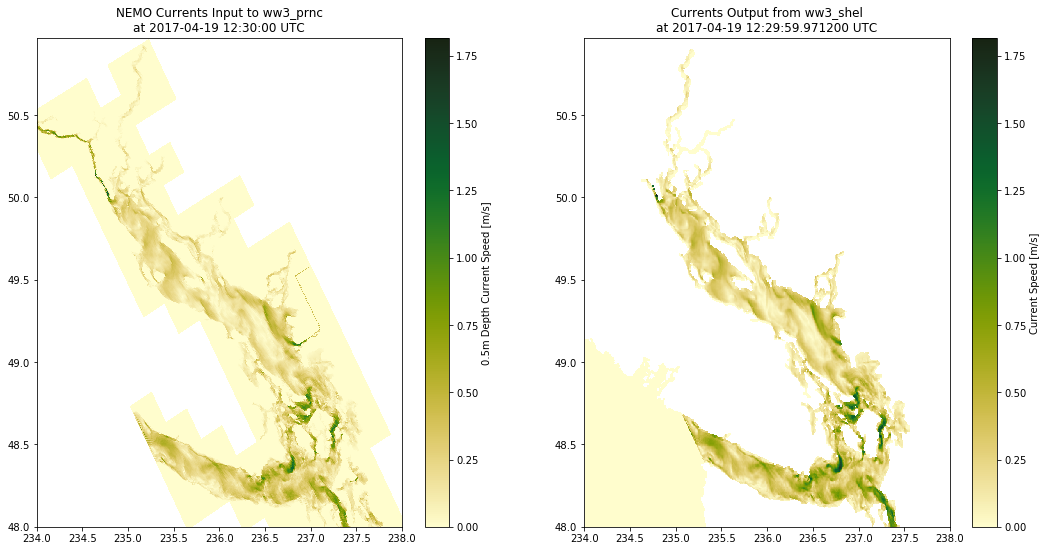

In [80]:
time = 12
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
mesh = axs[0].pcolormesh(
    nemo.longitude, nemo.latitude, ma.masked_invalid(np.sqrt(nemo.u_current[time]**2 + nemo.v_current[time]**2)),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label('0.5m Depth Current Speed [m/s]')
axs[0].set_title(f'NEMO Currents Input to ww3_prnc\nat {pd.to_datetime(nemo.time[time].values)} UTC')

axs[1].pcolormesh(
    # time*2+1 because wwf starts on the hour and has 30min interval vs. nemo 60min intervals on the half-hour
    wwf.longitude, wwf.latitude, ma.masked_invalid(np.sqrt(wwf.ucur[time*2+1]**2 + wwf.vcur[time*2+1]**2)),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label('Current Speed [m/s]')
axs[1].set_title(f'Currents Output from ww3_shel\nat {pd.to_datetime(wwf.time[time*2+1].values)} UTC')

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())